https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html?highlight=predict#Expectiles

In [1]:
import seaborn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/10718_Fall21/good_feature

/content/drive/MyDrive/10718_Fall21/good_feature


In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
from pandas.plotting import table
import scipy
from scipy.stats import pearsonr, spearmanr
from wordcloud import WordCloud, STOPWORDS
import datetime as dt
import plotly
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
# Load data


**cohort correction**

In [50]:
master = pd.read_csv('processed_mastersheet1025.zip')
master = master.drop(master[master.percent_fulfilled >= 1.0].index)
master.head(10)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.50,30.0,t,1,0.095643,401.86,0.500000,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.00,0.0,f,1,0.000000,233.24,0.500000,0.5
2,2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,NH,suburban,f,Mrs.,f,Environmental Science,Technology,moderate poverty,Grades 6-8,285.09,230.0,2013-12-31,3.0,35.0,29.0,390.0,0.0,0.0,0.00,0.0,f,1,0.000000,285.09,0.500000,0.5
3,3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,VA,urban,f,Ms.,f,Literacy,Other,highest poverty,Grades PreK-2,232.94,18.0,2013-12-31,3.0,34.0,18.0,187.0,1.0,0.0,42.50,0.0,f,1,0.182450,190.44,0.541667,0.6
4,4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,IL,urban,f,Mr.,f,Environmental Science,Supplies,highest poverty,Grades 6-8,513.41,70.0,2013-12-31,3.0,35.0,30.0,347.0,0.0,0.0,0.00,0.0,t,1,0.000000,513.41,0.000000,0.0
5,5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,SC,urban,f,Mrs.,f,Literature & Writing,Supplies,high poverty,Grades PreK-2,688.11,22.0,2013-12-31,6.0,32.0,15.0,187.0,2.0,0.0,42.50,24.5,f,1,0.061763,645.61,0.000000,0.0
6,6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,KY,urban,f,Mrs.,f,Literature & Writing,Technology,highest poverty,Grades PreK-2,935.16,25.0,2013-12-31,2.0,32.0,28.0,396.0,0.0,0.0,0.00,0.0,f,1,0.000000,935.16,0.625000,0.0
7,7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,FL,rural,f,Ms.,f,Literacy,Technology,highest poverty,Grades PreK-2,809.32,17.0,2013-12-31,2.0,34.0,19.0,443.0,2.0,1.0,709.75,9.5,t,1,0.876971,99.57,0.000000,0.0
11,11,c83d0794e67ec95f680cbb058c4523ff,535ab721f66316cf26a1d5ce1d9184f5,9f37b7e58dae8805882cbae215bb5e2a,FL,suburban,f,Mrs.,f,Applied Sciences,Books,high poverty,Grades 3-5,269.90,36.0,2013-12-31,3.0,36.0,28.0,192.0,0.0,0.0,0.00,0.0,f,1,0.000000,269.90,0.000000,0.0
12,12,3b6bddd1df0e310066d81c2b89771b5c,60a251a9fe882561405e9f6e135afb75,cf7b5a7b866094184208f0f4bc282e6a,NM,urban,f,Mrs.,f,Civics & Government,Technology,highest poverty,Grades 9-12,519.03,160.0,2013-12-31,5.0,38.0,11.0,194.0,0.0,0.0,0.00,0.0,t,1,0.000000,519.03,0.000000,0.0


In [51]:
t_mask = (master['date_posted'] >= '2013-02-01') & (master['date_posted'] <= '2013-07-31')
v_mask = (master['date_posted'] >= '2013-12-01') & (master['date_posted'] <= '2013-12-31')
train, validation = master.loc[t_mask], master.loc[v_mask]

In [52]:
def run_baseline1(df, k):
  if k == 0.0:
      precision, recall = 1, 0
  else:
      df.sort_values(by=['total_price_excluding_optional_support'], ascending = False, inplace = True)
      br = df['fully_funded'].value_counts().f / df.shape[0]
      if k == 1.0:
        precision, recall = br, 1
      else:
        sub = df.head(int(df.shape[0] * k)) # predict these as 1: not fully_funded, or 'f'
        rem = df.tail(df.shape[0] - int(df.shape[0] * k))
        tp = sub['fully_funded'].value_counts().f
        fp = sub.shape[0] - tp
        fn = rem['fully_funded'].value_counts().f
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  if k == 0.1:
    print('@k={:.2f}, precision={:.3f}, recall={:.3f}'.format(k, precision, recall))
  return precision, recall

In [53]:
grid = np.arange(0,1.1,0.1)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  tmp = run_baseline1(validation, k)
  pre_log[i], rec_log[i] = tmp[0], tmp[1]

@k=0.10, precision=0.720, recall=0.174


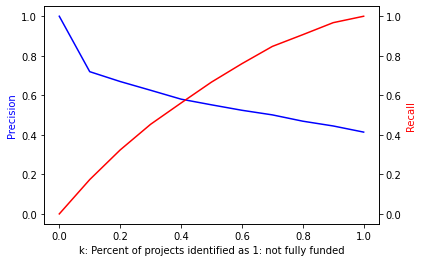

In [54]:
# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn import model_selection

from sklearn.metrics import precision_recall_curve, auc, roc_curve

**Preprocessing**

In [56]:
master = pd.read_csv('processed_mastersheet1025.zip')
master = master.drop(master[master.percent_fulfilled >= 1.0].index)
master.head(10)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.50,30.0,t,1,0.095643,401.86,0.500000,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.00,0.0,f,1,0.000000,233.24,0.500000,0.5
2,2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,NH,suburban,f,Mrs.,f,Environmental Science,Technology,moderate poverty,Grades 6-8,285.09,230.0,2013-12-31,3.0,35.0,29.0,390.0,0.0,0.0,0.00,0.0,f,1,0.000000,285.09,0.500000,0.5
3,3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,VA,urban,f,Ms.,f,Literacy,Other,highest poverty,Grades PreK-2,232.94,18.0,2013-12-31,3.0,34.0,18.0,187.0,1.0,0.0,42.50,0.0,f,1,0.182450,190.44,0.541667,0.6
4,4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,IL,urban,f,Mr.,f,Environmental Science,Supplies,highest poverty,Grades 6-8,513.41,70.0,2013-12-31,3.0,35.0,30.0,347.0,0.0,0.0,0.00,0.0,t,1,0.000000,513.41,0.000000,0.0
5,5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,SC,urban,f,Mrs.,f,Literature & Writing,Supplies,high poverty,Grades PreK-2,688.11,22.0,2013-12-31,6.0,32.0,15.0,187.0,2.0,0.0,42.50,24.5,f,1,0.061763,645.61,0.000000,0.0
6,6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,KY,urban,f,Mrs.,f,Literature & Writing,Technology,highest poverty,Grades PreK-2,935.16,25.0,2013-12-31,2.0,32.0,28.0,396.0,0.0,0.0,0.00,0.0,f,1,0.000000,935.16,0.625000,0.0
7,7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,FL,rural,f,Ms.,f,Literacy,Technology,highest poverty,Grades PreK-2,809.32,17.0,2013-12-31,2.0,34.0,19.0,443.0,2.0,1.0,709.75,9.5,t,1,0.876971,99.57,0.000000,0.0
11,11,c83d0794e67ec95f680cbb058c4523ff,535ab721f66316cf26a1d5ce1d9184f5,9f37b7e58dae8805882cbae215bb5e2a,FL,suburban,f,Mrs.,f,Applied Sciences,Books,high poverty,Grades 3-5,269.90,36.0,2013-12-31,3.0,36.0,28.0,192.0,0.0,0.0,0.00,0.0,f,1,0.000000,269.90,0.000000,0.0
12,12,3b6bddd1df0e310066d81c2b89771b5c,60a251a9fe882561405e9f6e135afb75,cf7b5a7b866094184208f0f4bc282e6a,NM,urban,f,Mrs.,f,Civics & Government,Technology,highest poverty,Grades 9-12,519.03,160.0,2013-12-31,5.0,38.0,11.0,194.0,0.0,0.0,0.00,0.0,t,1,0.000000,519.03,0.000000,0.0


In [57]:
master['date_posted'] = pd.to_datetime(master['date_posted'])
master.fully_funded = master.fully_funded.replace({'f':1, 't':0})
master.head(2)

,Unnamed: 0,projectid,teacher_acctid,schoolid,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,students_reached,date_posted,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,total_donation_amount,avg_msg_num_words,fully_funded,day_of_week_posted,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,IL,suburban,f,Mrs.,f,Special Needs,Other,moderate poverty,Grades 3-5,444.36,7.0,2013-12-31,8.0,33.0,10.0,220.0,1.0,0.0,42.5,30.0,0,1,0.095643,401.86,0.5,0.0
1,1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,ID,urban,f,Mrs.,f,Mathematics,Supplies,high poverty,Grades 3-5,233.24,30.0,2013-12-31,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.0,1,1,0.000000,233.24,0.5,0.5


 Convert Categorical data

In [58]:
import collections
def getMap(name):
    tmp = dict(master[name].value_counts())
    freq = list(reversed(sorted([tmp[i] for i in tmp])))
    res = collections.defaultdict(int)
    for key, val in tmp.items():
      res[key] = freq.index(val)
    return res


In [59]:
code_school_state = master["school_state"].map(getMap('school_state'))
code_school_state = code_school_state.fillna(code_school_state.mean())


In [60]:
code_school_metro = master['school_metro'].map(getMap('school_metro'))
code_school_metro = code_school_metro.fillna(code_school_metro.mean())

In [61]:
code_school_charter = master['school_charter'].map(getMap('school_charter'))

In [62]:
code_teacher_prefix = master['teacher_prefix'].map(getMap('teacher_prefix'))

In [63]:
code_teacher_teach_for_america = master['teacher_teach_for_america'].map(getMap('teacher_teach_for_america'))

In [64]:
code_primary_focus_subject = master['primary_focus_subject'].map(getMap('primary_focus_subject'))

In [65]:
code_resource_type = master['resource_type'].map(getMap('resource_type'))

In [66]:
code_poverty_level = master['poverty_level'].map(getMap('poverty_level'))

In [67]:
code_grade_level = master['grade_level'].map(getMap('grade_level'))

In [68]:
code_day_of_week_posted = master['day_of_week_posted'].map(getMap('day_of_week_posted'))

**No need for normalization**

In [69]:
# norm_code_school_state = (code_school_state - code_school_state.mean()) / code_school_state.std()
# norm_code_school_metro = (code_school_metro - code_school_metro.mean()) / code_school_metro.std()
# norm_code_school_charter = (code_school_charter - code_school_charter.mean()) / code_school_charter.std()
# norm_code_teacher_prefix = (code_teacher_prefix - code_teacher_prefix.mean()) / code_teacher_prefix.std()
# norm_code_teacher_teach_for_america = (code_teacher_teach_for_america - code_teacher_teach_for_america.mean()) / code_teacher_teach_for_america.std()
# norm_code_primary_focus_subject = (code_primary_focus_subject - code_primary_focus_subject.mean()) / code_primary_focus_subject.std()
# norm_code_resource_type = (code_resource_type - code_resource_type.mean()) / code_resource_type.std()
# norm_code_poverty_level = (code_poverty_level - code_poverty_level.mean()) / code_poverty_level.std()
# norm_code_grade_level = (code_grade_level - code_grade_level.mean()) / code_grade_level.std()
# norm_code_day_of_week_posted = (code_day_of_week_posted - code_day_of_week_posted.mean()) / code_day_of_week_posted.std()

In [25]:
# norm_code_teacher_prefix.isna().sum()

0

In [70]:
num_features = master[['total_price_excluding_optional_support','students_reached','title_num_words','description_num_words','statement_num_words','essay_num_words','num_donors','num_teachers','avg_msg_num_words','percent_fulfilled','amount_remaining','school_pct_funded','teacher_pct_funded']]
labels = master['fully_funded']

In [71]:
num_features.head()

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded
0,444.36,7.0,8.0,33.0,10.0,220.0,1.0,0.0,30.0,0.095643,401.86,0.500000,0.0
1,233.24,30.0,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.000000,233.24,0.500000,0.5
2,285.09,230.0,3.0,35.0,29.0,390.0,0.0,0.0,0.0,0.000000,285.09,0.500000,0.5
3,232.94,18.0,3.0,34.0,18.0,187.0,1.0,0.0,0.0,0.182450,190.44,0.541667,0.6
4,513.41,70.0,3.0,35.0,30.0,347.0,0.0,0.0,0.0,0.000000,513.41,0.000000,0.0


In [72]:
num_features['total_price_excluding_optional_support'] = num_features['total_price_excluding_optional_support'].clip(upper = 2000)
num_features['students_reached'] = num_features['students_reached'].clip(upper = 200)
num_features['statement_num_words'] = num_features['statement_num_words'].clip(upper = 250)
num_features['num_donors'] = num_features['num_donors'].clip(upper = 10)
num_features['num_teachers'] = num_features['num_teachers'].clip(upper = 5)
num_features['avg_msg_num_words'] = num_features['avg_msg_num_words'].clip(upper = 100)
num_features['amount_remaining'] = num_features['amount_remaining'].clip(upper = 2000)

**no need for normalization**

In [29]:
# norm_num_features = (num_features - num_features.mean())/num_features.std()

In [73]:
num_features.isna().sum()

total_price_excluding_optional_support       0
students_reached                           116
title_num_words                             15
description_num_words                       89
statement_num_words                       1292
essay_num_words                              3
num_donors                                   0
num_teachers                                 0
avg_msg_num_words                            0
percent_fulfilled                          299
amount_remaining                             0
school_pct_funded                            0
teacher_pct_funded                           0
dtype: int64

In [74]:
num_features['students_reached'] = num_features['students_reached'].fillna(num_features['students_reached'].mean())
num_features['title_num_words'] = num_features['title_num_words'].fillna(num_features['title_num_words'].mean())
num_features['description_num_words'] = num_features['description_num_words'].fillna(num_features['description_num_words'].mean())
num_features['statement_num_words'] = num_features['statement_num_words'].fillna(num_features['statement_num_words'].mean())
num_features['percent_fulfilled'] = num_features['percent_fulfilled'].fillna(num_features['percent_fulfilled'].mean())
num_features['essay_num_words'] = num_features['essay_num_words'].fillna(num_features['essay_num_words'].mean())


In [75]:
num_features.isna().sum()

total_price_excluding_optional_support    0
students_reached                          0
title_num_words                           0
description_num_words                     0
statement_num_words                       0
essay_num_words                           0
num_donors                                0
num_teachers                              0
avg_msg_num_words                         0
percent_fulfilled                         0
amount_remaining                          0
school_pct_funded                         0
teacher_pct_funded                        0
dtype: int64

In [76]:
from scipy.sparse import hstack
features = pd.concat([num_features, code_school_state, code_school_metro, code_school_charter, code_teacher_prefix, code_teacher_teach_for_america, code_primary_focus_subject, code_resource_type, code_poverty_level, code_grade_level, code_day_of_week_posted], axis = 1)
features.shape

(526994, 23)

In [77]:
features.head(2)

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,day_of_week_posted
0,444.36,7.0,8.0,33.0,10.0,220.0,1.0,0.0,30.0,0.095643,401.86,0.5,0.0,3,1,0,0,0,3,3,2,1,1
1,233.24,30.0,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.000000,233.24,0.5,0.5,41,0,0,0,0,2,0,1,1,1


In [78]:
t_mask = (master['date_posted'] >= '2013-02-01') & (master['date_posted'] <= '2013-07-31')
v_mask = (master['date_posted'] >= '2013-12-01') & (master['date_posted'] <= '2013-12-31')

In [79]:
X_train, y_train = features.loc[t_mask], labels.loc[t_mask]
X_test, y_test = features.loc[v_mask], labels.loc[v_mask]

In [80]:
X_train, y_train, X_test, y_test = X_train.values, y_train.values, X_test.values, y_test.values
print(X_train.shape, X_test.shape)

(34388, 23) (6998, 23)


In [81]:
import sys
sys.path.append('/content/drive/MyDrive/10718_Fall21/')
# drive/MyDrive/10718_Fall21/

In [82]:
def prk(df, k):
  if k == 0.0:
      precision, recall = 1, 0
  else:
      df.sort_values(by=['pred'], ascending = False, inplace = True)
      br = df['fully_funded'].sum() / df.shape[0]
      if k == 1.0:
        precision, recall = br, 1
      else:
        sub = df.head(int(df.shape[0] * k)) # predict these as 1: not fully_funded, or 'f'
        rem = df.tail(df.shape[0] - int(df.shape[0] * k))
        tp = sub['fully_funded'].sum()
        fp = sub.shape[0] - tp
        fn = rem['fully_funded'].sum()
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  # if k == 0.1:
  #   print('@k={:.2f}, precision={:.3f}, recall={:.3f}'.format(k, precision, recall))
  return precision, recall

In [41]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 4.3 MB/s 


In [83]:
features.head()

,total_price_excluding_optional_support,students_reached,title_num_words,description_num_words,statement_num_words,essay_num_words,num_donors,num_teachers,avg_msg_num_words,percent_fulfilled,amount_remaining,school_pct_funded,teacher_pct_funded,school_state,school_metro,school_charter,teacher_prefix,teacher_teach_for_america,primary_focus_subject,resource_type,poverty_level,grade_level,day_of_week_posted
0,444.36,7.0,8.0,33.0,10.0,220.0,1.0,0.0,30.0,0.095643,401.86,0.500000,0.0,3,1,0,0,0,3,3,2,1,1
1,233.24,30.0,3.0,33.0,14.0,175.0,0.0,0.0,0.0,0.000000,233.24,0.500000,0.5,41,0,0,0,0,2,0,1,1,1
2,285.09,200.0,3.0,35.0,29.0,390.0,0.0,0.0,0.0,0.000000,285.09,0.500000,0.5,44,1,0,0,0,6,1,2,2,1
3,232.94,18.0,3.0,34.0,18.0,187.0,1.0,0.0,0.0,0.182450,190.44,0.541667,0.6,15,0,0,1,0,0,3,0,0,1
4,513.41,70.0,3.0,35.0,30.0,347.0,0.0,0.0,0.0,0.000000,513.41,0.000000,0.0,3,0,0,2,0,6,0,0,2,1


In [94]:
for i, f in enumerate(list(features.columns)):
  print(i, f, end = '|')

0 total_price_excluding_optional_support|1 students_reached|2 title_num_words|3 description_num_words|4 statement_num_words|5 essay_num_words|6 num_donors|7 num_teachers|8 avg_msg_num_words|9 percent_fulfilled|10 amount_remaining|11 school_pct_funded|12 teacher_pct_funded|13 school_state|14 school_metro|15 school_charter|16 teacher_prefix|17 teacher_teach_for_america|18 primary_focus_subject|19 resource_type|20 poverty_level|21 grade_level|22 day_of_week_posted|

100% (11 of 11) |########################| Elapsed Time: 0:02:32 Time:  0:02:32


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warn

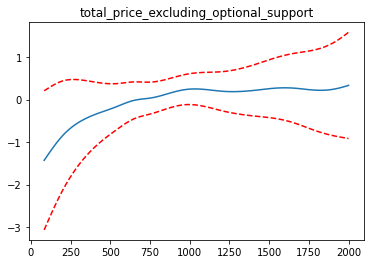

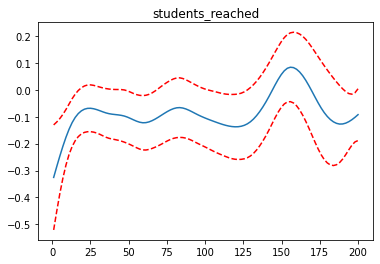

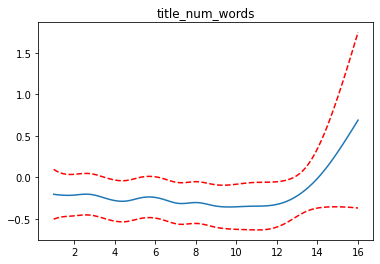

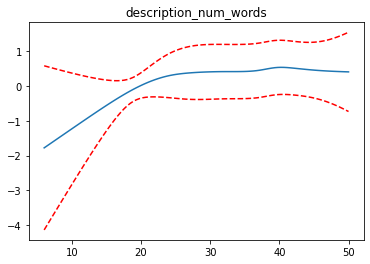

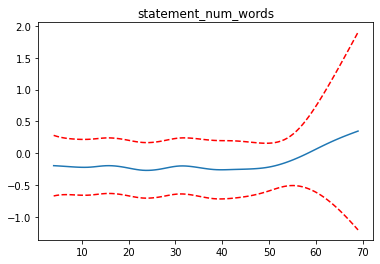

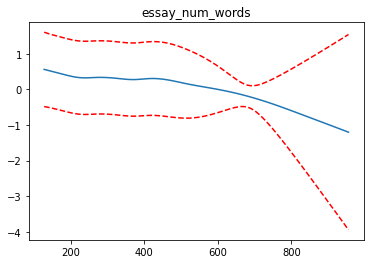

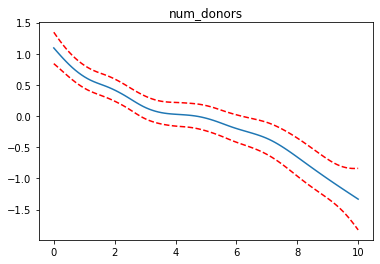

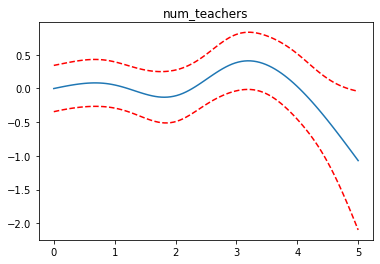

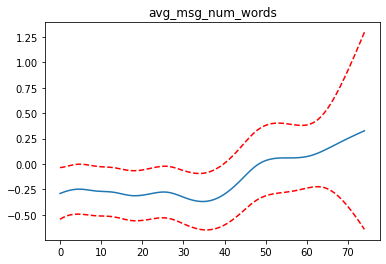

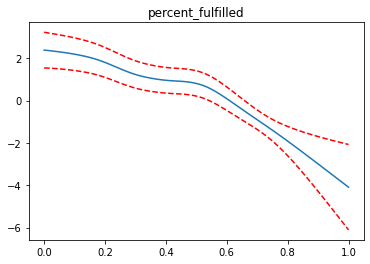

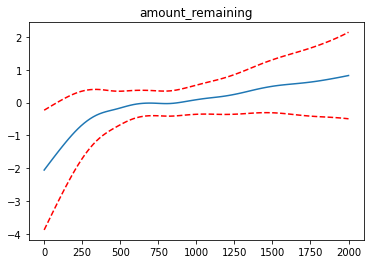

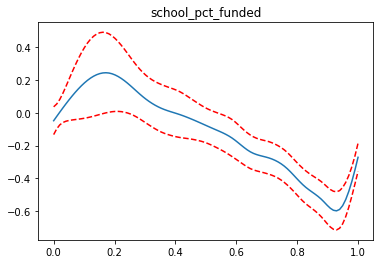

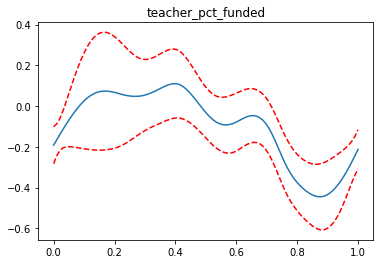

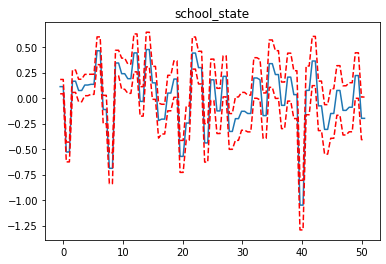

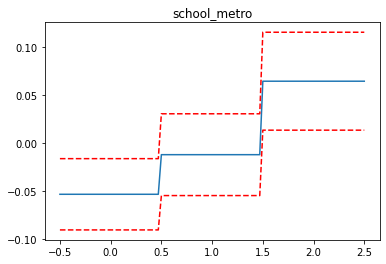

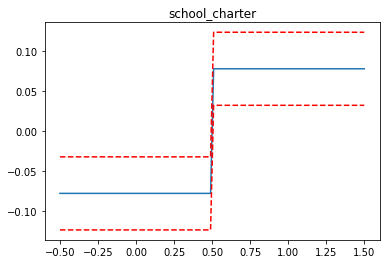

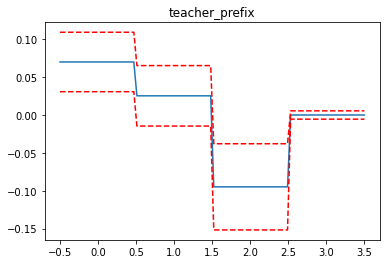

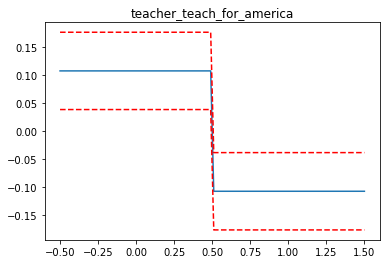

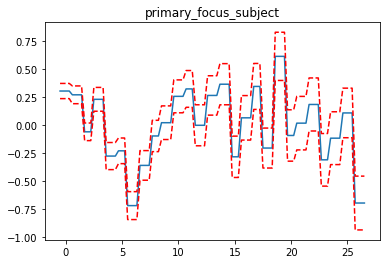

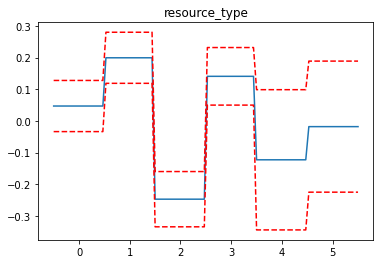

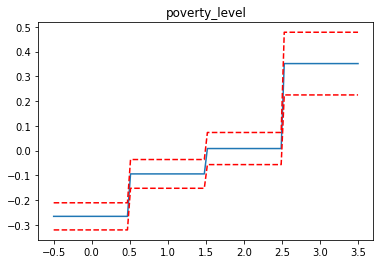

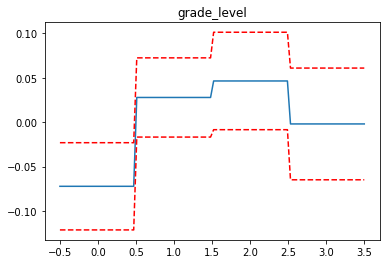

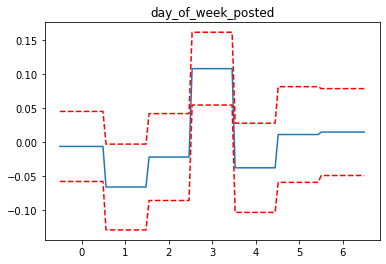

In [116]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default



gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) +
                  s(7) + s(8) + s(9) + s(10) + s(11) + s(12) +
                  f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) +
                  f(20) + f(21) + f(22)).gridsearch(X_train, y_train)

# gam = LogisticGAM(s(0) + s(1) + s(2)).gridsearch(X_train, y_train)



for i, _ in enumerate(list(features.columns)):
    print(i)
    fig, ax = plt.subplots()
    titles = list(features.columns)
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [118]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    169.7818
Link Function:                        LogitLink Log Likelihood:                                -18030.9287
Number of Samples:                        34388 AIC:                                            36401.4211
                                                AICc:                                           36403.1359
                                                UBRE:                                               3.0625
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.224
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [142]:
def GAMPRK(model):
  print('fitting rf')
  # model = RandomForestClassifier(n_estimators = 500, min_samples_split = 25, random_state=0)
  # model.fit(X_train, y_train)
  n = X_test.shape[0]
  gam_prob = np.zeros(n)
  for i in range(n):
    
      if i % 100 == 0:
          print('@ i = ', i)
      x = X_test[i, :]

      
      gam_pred = model.predict_proba([x])[0]

      gam_prob[i] = gam_pred
  return gam_prob

In [143]:
gam_prob = GAMPRK(gam)

fitting rf
@ i =  0
@ i =  100
@ i =  200
@ i =  300
@ i =  400
@ i =  500
@ i =  600
@ i =  700
@ i =  800
@ i =  900
@ i =  1000
@ i =  1100
@ i =  1200
@ i =  1300
@ i =  1400
@ i =  1500
@ i =  1600
@ i =  1700
@ i =  1800
@ i =  1900
@ i =  2000
@ i =  2100
@ i =  2200
@ i =  2300
@ i =  2400
@ i =  2500
@ i =  2600
@ i =  2700
@ i =  2800
@ i =  2900
@ i =  3000
@ i =  3100
@ i =  3200
@ i =  3300
@ i =  3400
@ i =  3500
@ i =  3600
@ i =  3700
@ i =  3800
@ i =  3900
@ i =  4000
@ i =  4100
@ i =  4200
@ i =  4300
@ i =  4400
@ i =  4500
@ i =  4600
@ i =  4700
@ i =  4800
@ i =  4900
@ i =  5000
@ i =  5100
@ i =  5200
@ i =  5300
@ i =  5400
@ i =  5500
@ i =  5600
@ i =  5700
@ i =  5800
@ i =  5900
@ i =  6000
@ i =  6100
@ i =  6200
@ i =  6300
@ i =  6400
@ i =  6500
@ i =  6600
@ i =  6700
@ i =  6800
@ i =  6900


precision @ k = 0.8297567954220315


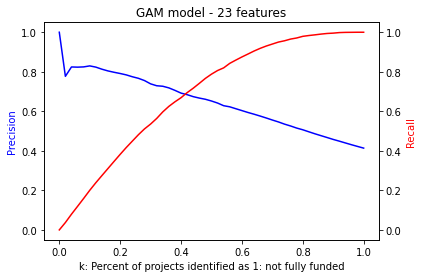

In [145]:
y_test_pred = gam_prob
Y_test = y_test
y_score = pd.Series(y_test_pred)
Y_test_np = Y_test
Y_test_pd = pd.Series(Y_test_np)
combo = pd.concat([Y_test_pd, y_score], axis=1)
combo.columns = ['fully_funded', 'pred']

grid = np.arange(0,1.02,0.02)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  pre_log[i], rec_log[i] = prk(combo, k)
  if k == 0.1:
    print('precision @ k = {}'.format(pre_log[i]))

# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
plt.title('GAM model - 23 features')
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()

In [147]:
for i, f in enumerate(list(features.columns)):
  print(i, f, end = '|')

0 total_price_excluding_optional_support|1 students_reached|2 title_num_words|3 description_num_words|4 statement_num_words|5 essay_num_words|6 num_donors|7 num_teachers|8 avg_msg_num_words|9 percent_fulfilled|10 amount_remaining|11 school_pct_funded|12 teacher_pct_funded|13 school_state|14 school_metro|15 school_charter|16 teacher_prefix|17 teacher_teach_for_america|18 primary_focus_subject|19 resource_type|20 poverty_level|21 grade_level|22 day_of_week_posted|

In [158]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default



gam_subset = LogisticGAM(s(0) + s(6) + 
                  s(7) + s(8) + s(9) + s(10) +
                  f(17) + f(18) + f(19) +
                  f(20)).gridsearch(X_train, y_train)

oracle = [0, 6, 7, 8, 9, 10, 17, 18, 19, 20]

# gam_subset = LogisticGAM(s(0) + s(1) + 
#                   s(2)).gridsearch(X_train, y_train)




100% (11 of 11) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


0 total_price_excluding_optional_support
1 students_reached
2 title_num_words
3 description_num_words
4 statement_num_words
5 essay_num_words
6 num_donors
7 num_teachers
8 avg_msg_num_words
9 percent_fulfilled


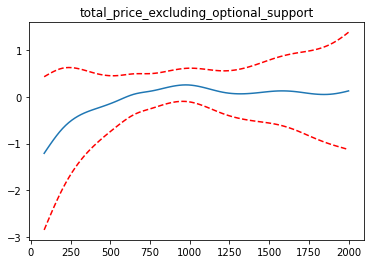

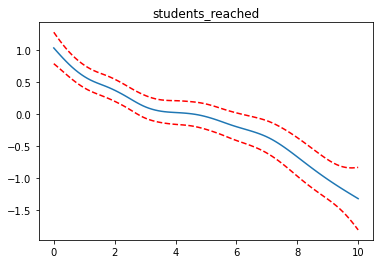

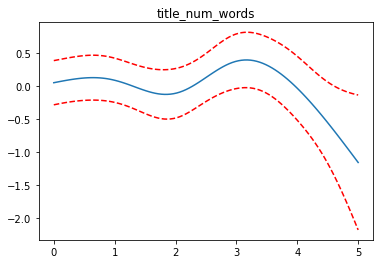

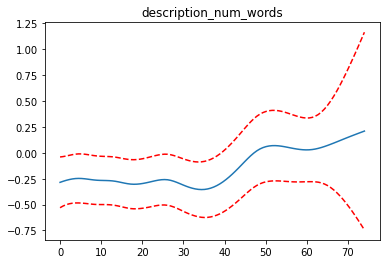

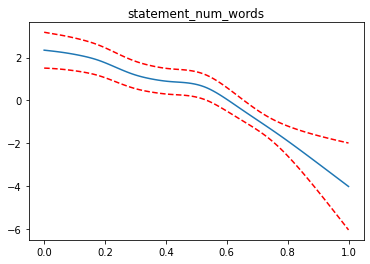

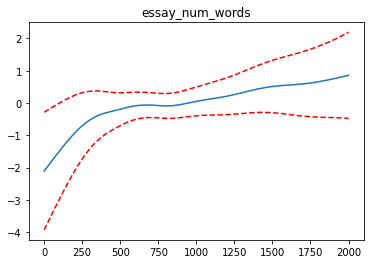

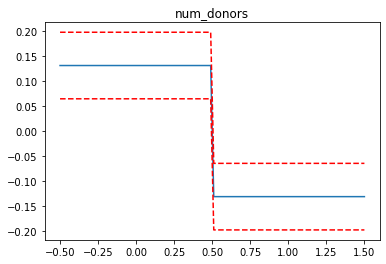

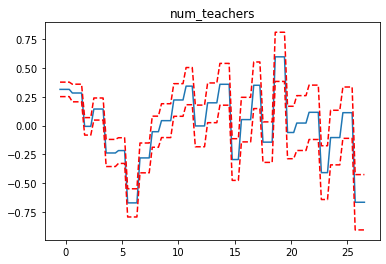

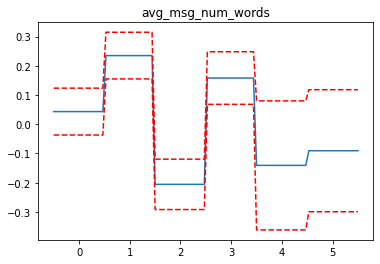

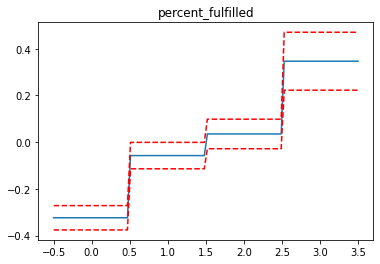

In [175]:
titles = list(features.columns)
for i in range(10):
    print(i, end = ' ')

    print(titles[i])
    fig, ax = plt.subplots()
    XX = gam_subset.generate_X_grid(term = i)
    pdep, confi = gam_subset.partial_dependence(term = i, width=.95)

    ax.plot(XX[:, oracle[i]], pdep)
    ax.plot(XX[:, oracle[i]], confi, c='r', ls='--')
    ax.set_title(titles[i]);


In [162]:
gam_subset_prob = GAMPRK(gam_subset)

fitting rf
@ i =  0
@ i =  100
@ i =  200
@ i =  300
@ i =  400
@ i =  500
@ i =  600
@ i =  700
@ i =  800
@ i =  900
@ i =  1000
@ i =  1100
@ i =  1200
@ i =  1300
@ i =  1400
@ i =  1500
@ i =  1600
@ i =  1700
@ i =  1800
@ i =  1900
@ i =  2000
@ i =  2100
@ i =  2200
@ i =  2300
@ i =  2400
@ i =  2500
@ i =  2600
@ i =  2700
@ i =  2800
@ i =  2900
@ i =  3000
@ i =  3100
@ i =  3200
@ i =  3300
@ i =  3400
@ i =  3500
@ i =  3600
@ i =  3700
@ i =  3800
@ i =  3900
@ i =  4000
@ i =  4100
@ i =  4200
@ i =  4300
@ i =  4400
@ i =  4500
@ i =  4600
@ i =  4700
@ i =  4800
@ i =  4900
@ i =  5000
@ i =  5100
@ i =  5200
@ i =  5300
@ i =  5400
@ i =  5500
@ i =  5600
@ i =  5700
@ i =  5800
@ i =  5900
@ i =  6000
@ i =  6100
@ i =  6200
@ i =  6300
@ i =  6400
@ i =  6500
@ i =  6600
@ i =  6700
@ i =  6800
@ i =  6900


precision @ k = 0.8154506437768241


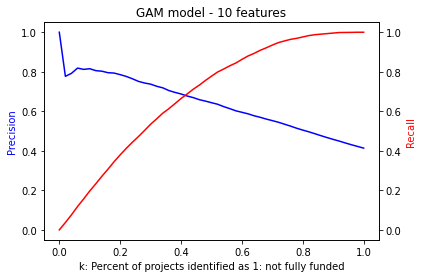

In [176]:
y_test_pred = gam_subset_prob
Y_test = y_test
y_score = pd.Series(y_test_pred)
Y_test_np = Y_test
Y_test_pd = pd.Series(Y_test_np)
combo = pd.concat([Y_test_pd, y_score], axis=1)
combo.columns = ['fully_funded', 'pred']

grid = np.arange(0,1.02,0.02)
pre_log, rec_log = np.zeros_like(grid), np.zeros_like(grid)
for i, k in enumerate(grid):
  pre_log[i], rec_log[i] = prk(combo, k)
  if k == 0.1:
    print('precision @ k = {}'.format(pre_log[i]))

# f, axs = plt.subplots(1,2,figsize=(15,5))
# axs1 = axs[0]
f, axs1 = plt.subplots()
plt.title('GAM model - 10 features')
axs2 = axs1.twinx()
axs1.plot(grid, pre_log, 'b', label = 'Precision')
axs2.plot(grid, rec_log, 'r', label = 'Recall')
axs1.set_ylabel('Precision', color = 'b')
axs1.set_ylim(-0.05,1.05)
axs2.set_ylabel('Recall', color = 'r')
axs2.set_ylim(-0.05,1.05)
axs1.set_xlabel('k: Percent of projects identified as 1: not fully funded')
plt.show()